# Buildingblocks of the model in theano

In [1]:
import numpy as np
import theano
import theano.tensor as tt
import pymc3 as pm

import matplotlib.pyplot as plt

theano.config.optimizer="None"


## Lognormal Distribution
(as taken from https://github.com/Priesemann-Group/covid19_inference_forecast)

In [2]:
def tt_lognormal(x, mu, sigma):
    x = tt.clip(x,1e-12,1e12) # Checks to improve stability and resilience against NANs
#    mu = tt.clip(mu,1e-12,1)
#    sigma = tt.clip(sigma,1e-12,1e12)
    
    distr = 1/x* tt.exp(-((tt.log(x) - mu) ** 2) / (2 * sigma ** 2))
    return distr / (tt.sum(distr, axis=0)+1e-9)

In [ ]:
print(tt_lognormal(np.arange(10),4,.443))

s_beta = tt_lognormal(d, tt.log(s_median_incubation), s_sigma_incubation)
f_beta = theano.function([d,s_median_incubation,s_sigma_incubation],[s_beta])

for m in [4,5,6,7]:
    plt.plot(f_beta(np.arange(16),m,.443)[0])

## S(I)R Model
* tt.roll right shifts the internal state by one
* tt_set_subtensor sets the first element of the internal state to the new (imported) cases.
No Infection is calculated

In [ ]:
# Working model with shifting internal state instead of taps
# Theano symbolic Variables
d = tt.vector()
s_median_incubation = tt.scalar()
s_sigma_incubation = tt.scalar()

def SIR_model_noInfect(imported_t,l=16):
        
    s_imported_t = tt.vector()
    s_lambda_t = tt.vector()
    p_infected = tt.fvector("internal state")
    
    def imported_day_acc(imported_at_t,p_infected):
        new = imported_at_t
        p_infected = tt.roll(p_infected,1,0)
        p_infected = tt.set_subtensor(p_infected[:1],new,inplace=False)
        return p_infected
    
    outputs_info = [np.zeros(l)]
    infected_t,updates = theano.scan(fn=imported_day_acc,sequences=[s_imported_t],outputs_info=outputs_info)
    
    # Create a function using the symbolic expressions defined above
    calc_infected = theano.function(inputs=[s_imported_t],outputs=infected_t,updates=updates)
    # Run that function
    return calc_infected(imported_t)

In [ ]:
imported_t = [0,1,2,3,0,0,0,0]
print("Last internal state",SIR_model_noInfect(imported_t)[-1] )

## SIR Model
New infections are calculated on internal state (dot) lognormal infection - distribution

In [7]:
# Model that takes imported cases and holds internal state of new_infected on last l days. 
# new_infected = dot ( infected_of_last_days , beta_distr ) 
# sequences (if any), prior result(s) (if needed), non-sequences (if any)

# Theano symbolic Variables
d = tt.vector()
s_median_incubation = tt.scalar()
s_sigma_incubation = tt.scalar()

s_beta = tt_lognormal(d, tt.log(s_median_incubation), s_sigma_incubation)
f_beta = theano.function([d,s_median_incubation,s_sigma_incubation],[s_beta])

def SIR_model(imported_t,lambda_t, median_incubation,sigma_incubation,l=16):
    beta = f_beta(range(l),median_incubation,sigma_incubation)[0]
    
    s_imported_t = tt.vector()
    s_lambda_t = tt.vector()
    s_infected_t = tt.vector()
    p_infected = tt.dvector("internal state")
    
    def next_day(lambda_at_t,imported_at_t,p_infected,beta):
        new = imported_at_t + theano.dot(p_infected,beta) * lambda_at_t
        p_infected = tt.roll(p_infected,1,0)
        p_infected = tt.set_subtensor(p_infected[:1],new,inplace=False)
        return new,p_infected
    # Initial internal state
    outputs_info = [None,np.zeros(l)]
    infected_t,updates = theano.scan(fn=next_day,
                                     sequences=[s_lambda_t,s_imported_t],
                                     outputs_info=outputs_info,
                                     non_sequences=beta)
    # Create a function using the symbolic expressions defined above
    calc_infected = theano.function(inputs=[s_lambda_t,s_imported_t],outputs=infected_t,updates=updates)
    # Run that function
    newI,I = calc_infected(lambda_t,imported_t)
    return newI

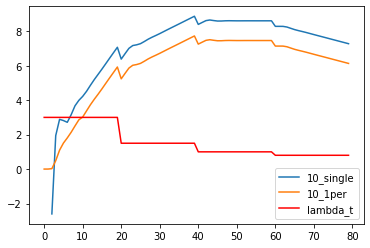

In [16]:
dur = 20
imported1_t = np.array( [10.]+[0.]*(dur*5-1) )
imported2_t = np.array( [1.]*10+[0.]*(dur*5-10) )

lambda_t = np.array( [3.]*dur+[1.5]*dur+[1]*dur+[.8]*dur )

median,sigma = 4.,0.433

# Test two different initial distributions
for k,imp in {"10_single":imported1_t,"10_1per":imported2_t}.items():
    plt.plot( np.log(SIR_model(imp,lambda_t,median,sigma))/np.log(2),label=k )
plt.plot(lambda_t,color="red",label="lambda_t")
plt.legend()

## SEIR model
newly infected with factor *f* modelling exposed i.e. not immune
E_t counts exposed as internal state

In [34]:
# sequences (if any), prior result(s) (if needed), non-sequences (if any)
s_beta = tt_lognormal(d, tt.log(s_median_incubation), s_sigma_incubation)
f_beta = theano.function([d,s_median_incubation,s_sigma_incubation],[s_beta])

def SIER_model(N, imported_t,lambda_t, median_incubation,sigma_incubation,l=16):
    N = tt.cast(N,'float64')
    beta = f_beta(range(l),median_incubation,sigma_incubation)[0]
  #  beta = beta/sum(beta)
    
    s_imported_t = tt.dvector()
    s_lambda_t = tt.dvector()
    s_infected_t = tt.dvector()
    p_infected = tt.dvector("internal state")
    

    def imported_day_acc(lambda_at_t,imported_at_t,p_infected,E_t,beta,N):
        f = E_t / N
        new = imported_at_t + theano.dot(p_infected,beta) * lambda_at_t * f
        p_infected = tt.roll(p_infected,1,0)
        p_infected = tt.set_subtensor(p_infected[:1],new,inplace=False)
        return new,p_infected,E_t-new
    
    outputs_info = [None,np.zeros(l),N]
    infected_t,updates = theano.scan(fn=imported_day_acc,
                                     sequences=[s_lambda_t,s_imported_t],
                                     outputs_info=outputs_info,
                                     non_sequences=[beta,N])
    calc_infected = theano.function(inputs=[s_lambda_t,s_imported_t],outputs=infected_t,updates=updates)
    
    newI,I,E_t = calc_infected(lambda_t,imported_t)
    return newI,E_t,

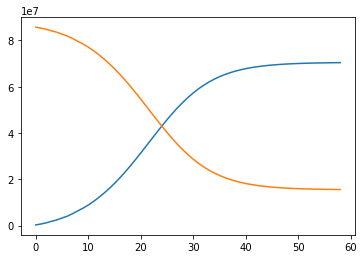

In [50]:
median,sigma = 4.,0.433
imported_t = np.array([3e5,4e5,5e5,6e5,3e5,4e5,1e5,2e5,2e5]+[0]*50,dtype=np.float64)
lambda_t = np.array([2]*len(imported_t),dtype=np.float64)

newI,E_t = SIER_model(86e6,imported_t,lambda_t,median,sigma,l=40)

plt.plot(np.cumsum(newI))
plt.plot(E_t)